In [1]:
import os, gc, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import default_rng
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve
from sklearn.decomposition import PCA

# Carpetas de salida
RES_DIR = Path("resultados"); RES_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figuras");    FIG_DIR.mkdir(exist_ok=True)

SEED = 7
rng = default_rng(SEED)

In [ ]:
def standardize_cols(X: np.ndarray) -> np.ndarray:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-9
    return (X - mu) / sd

def add_noise_dims(X, D_target, sigma=0.5, rng=None):
    """Añade dimensiones de ruido gaussiano hasta alcanzar D_target."""
    rng = rng or default_rng()
    n, d = X.shape
    if D_target <= d:
        return X[:, :D_target]
    extra = rng.normal(0.0, sigma, size=(n, D_target - d))
    return np.hstack([X, extra])

def est_d_intrinseca_pca(X, var_thr=0.95):
    """Estimación grosera de dimensión intrínseca: nº de componentes que explican var_thr."""
    dmax = min(X.shape[0]-1, X.shape[1])
    pca = PCA(n_components=dmax, svd_solver="randomized", random_state=SEED)
    pca.fit(X)
    cs = np.cumsum(pca.explained_variance_ratio_)
    return int(np.searchsorted(cs, var_thr) + 1)

def bench_knn(X, algorithm="kd_tree", metric="euclidean", k=15,
              leaf_size=30, n_query=1000, reps=2, seed=SEED,
              check_correct=False, correct_subset=300):
    """
    Devuelve tiempos de construcción/consulta medios (y std). Opcionalmente, correctitud vs brute.
    """
    rng = default_rng(seed)
    n = X.shape[0]
    q_idx = rng.choice(n, size=min(n_query, n), replace=False)
    Xq = X[q_idx]

    fit_t, qry_t = [], []

    # Correctitud (opcional, subgrupo)
    correct_rate = None
    if check_correct:
        ref = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric).fit(X)
        ref_idx = ref.kneighbors(Xq[:min(correct_subset, Xq.shape[0])], return_distance=False)

    # Repeticiones
    for _ in range(reps):
        gc.collect()
        t0 = time.perf_counter()
        nn = NearestNeighbors(n_neighbors=k, algorithm=algorithm, metric=metric, leaf_size=leaf_size)
        nn.fit(X)
        fit_t.append(time.perf_counter() - t0)

        t0 = time.perf_counter()
        _ = nn.kneighbors(Xq, return_distance=False)
        qry_t.append(time.perf_counter() - t0)

    # Correctitud 
    if check_correct:
        nn = NearestNeighbors(n_neighbors=k, algorithm=algorithm, metric=metric, leaf_size=leaf_size).fit(X)
        idx_small = nn.kneighbors(Xq[:min(correct_subset, Xq.shape[0])], return_distance=False)
        correct_rate = float((idx_small == ref_idx).all(axis=1).mean())

    return {
        "fit_mean": float(np.mean(fit_t)), "fit_std": float(np.std(fit_t)),
        "qry_mean": float(np.mean(qry_t)), "qry_std": float(np.std(qry_t)),
        "correct_rate": correct_rate
    }

def plot_query_vs_D(df, title, file_out):
    """Curva de tiempo de consulta vs D, una línea por algoritmo."""
    algos = sorted(df["algorithm"].unique())
    Ds = sorted(df["D"].unique())
    fig, ax = plt.subplots(figsize=(6, 4))
    for algo in algos:
        sub = df[df["algorithm"]==algo].sort_values("D")
        ax.plot(sub["D"], sub["qry_mean"], marker="o", label=algo)
        ax.fill_between(sub["D"], sub["qry_mean"]-sub["qry_std"], sub["qry_mean"]+sub["qry_std"], alpha=0.2)
    ax.set_xlabel("Dimensión ambiente (D)")
    ax.set_ylabel("Tiempo de consulta (s)")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    fig.savefig(FIG_DIR / file_out, dpi=150)
    plt.show()

def winrate_small(df):
    """Tabla compacta: % de victorias por algoritmo (consulta más rápida) en el DataFrame dado."""
    grp = df.groupby(["D","algorithm"])["qry_mean"].median().reset_index()
    winners = grp.loc[grp.groupby("D")["qry_mean"].idxmin()]
    counts = winners["algorithm"].value_counts(normalize=True).mul(100).round(1)
    return counts.rename("porcentaje").to_frame()

In [ ]:
N_MAIN      = 10000          # tamaño de muestra
D_LIST      = [5, 10, 20, 50]
K_LIST      = [15]           # k principal
METRICS     = ["euclidean", "manhattan"]
ALGORITHMS  = ["kd_tree", "ball_tree", "brute"]
REPS        = 2
N_QUERY     = 1000
LEAF        = 30

rowsA = []

for family in ["uniform", "gaussian"]:
    for D in D_LIST:
        # Generación de datos
        if family == "uniform":
            X = rng.uniform(0, 1, size=(N_MAIN, D))
        else:
            X, _ = make_blobs(n_samples=N_MAIN, n_features=D, centers=10,
                              cluster_std=1.0, random_state=SEED)
        X = standardize_cols(X)

        for metric in METRICS:
            for k in K_LIST:
                NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric).fit(X)
                for algo in ALGORITHMS:
                    out = bench_knn(X, algorithm=algo, metric=metric, k=k,
                                    leaf_size=LEAF, n_query=N_QUERY, reps=REPS,
                                    seed=SEED, check_correct=False)
                    rowsA.append({
                        "family": family, "N": N_MAIN, "D": D,
                        "metric": metric, "k": k, "algorithm": algo,
                        **out
                    })

dfA = pd.DataFrame(rowsA)
dfA.to_csv(RES_DIR / "A_dim_resultados_compacto.csv", index=False)
dfA.head()

,family,N,D,metric,k,algorithm,fit_mean,fit_std,qry_mean,qry_std,correct_rate
0,uniform,10000,5,euclidean,15,kd_tree,0.009252,3.519000e-04,0.010801,0.000109,None
1,uniform,10000,5,euclidean,15,ball_tree,0.006322,3.803000e-04,0.018257,0.000113,None
2,uniform,10000,5,euclidean,15,brute,0.000364,7.160000e-05,0.822040,0.809724,None
3,uniform,10000,5,manhattan,15,kd_tree,0.010677,1.906200e-03,0.016186,0.003422,None
4,uniform,10000,5,manhattan,15,ball_tree,0.006082,4.999993e-08,0.024612,0.000144,None


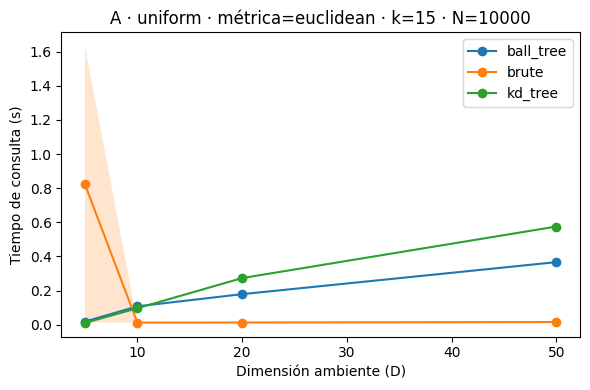

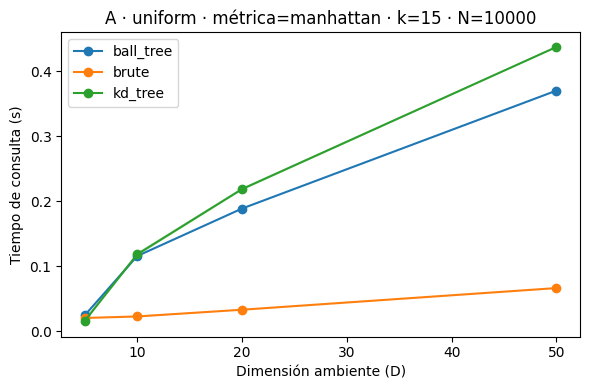

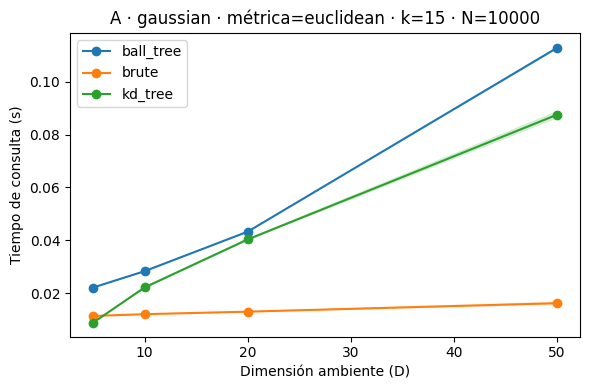

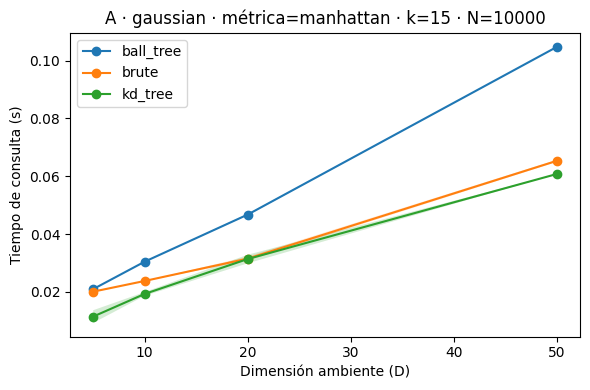

,algorithm,family,metric,porcentaje
0,brute,uniform,euclidean,75.0
1,kd_tree,uniform,euclidean,25.0
2,brute,uniform,manhattan,75.0
3,kd_tree,uniform,manhattan,25.0
4,brute,gaussian,euclidean,75.0
5,kd_tree,gaussian,euclidean,25.0
6,kd_tree,gaussian,manhattan,100.0


In [4]:
# Curvas
for fam in ["uniform", "gaussian"]:
    for metric in METRICS:
        sub = dfA[(dfA["family"]==fam) & (dfA["metric"]==metric)]
        if sub.empty: 
            continue
        title = f"A · {fam} · métrica={metric} · k={K_LIST[0]} · N={N_MAIN}"
        file_out = f"A_{fam}_{metric}_qry_vsD.png"
        plot_query_vs_D(sub, title, file_out)

# Tablas compactas de victorias
summaryA = []
for fam in ["uniform", "gaussian"]:
    for metric in METRICS:
        sub = dfA[(dfA["family"]==fam) & (dfA["metric"]==metric)]
        if sub.empty: 
            continue
        wr = winrate_small(sub.reset_index(drop=True))
        wr.insert(0, "family", fam)
        wr.insert(1, "metric", metric)
        summaryA.append(wr.reset_index().rename(columns={"index":"algorithm"}))

dfA_win = pd.concat(summaryA, ignore_index=True)
dfA_win.to_csv(RES_DIR / "A_dim_winrate_compacto.csv", index=False)
dfA_win


In [ ]:
N_MANIFOLD  = 8000
D_MAN_LIST  = [10, 20, 50]
SIGMA_LIST  = [0.0, 0.2, 0.5]
METRICS_B   = ["euclidean", "manhattan"]
ALGOS_B     = ["kd_tree", "ball_tree"]
REPS_B      = 2
N_QUERY_B   = 1000
K_B         = 15

rowsB = []

for base in ["swiss", "scurve"]:
    for D in D_MAN_LIST:
        for sigma in SIGMA_LIST:
            # Generación base 3D
            if base == "swiss":
                X3, _ = make_swiss_roll(n_samples=N_MANIFOLD, noise=0.0, random_state=SEED)
            else:
                X3, _ = make_s_curve(n_samples=N_MANIFOLD, noise=0.0, random_state=SEED)

            X3 = standardize_cols(X3)
            X  = add_noise_dims(X3, D_target=D, sigma=sigma, rng=rng)
            X  = standardize_cols(X)  # estandarizamos de nuevo en D dimensiones

            # Estimación PCA de dimensión intrínseca 
            dstar = est_d_intrinseca_pca(X, var_thr=0.95)

            for metric in METRICS_B:
                NearestNeighbors(n_neighbors=K_B, algorithm="brute", metric=metric).fit(X)
                for algo in ALGOS_B:
                    out = bench_knn(X, algorithm=algo, metric=metric, k=K_B,
                                    leaf_size=LEAF, n_query=N_QUERY_B, reps=REPS_B,
                                    seed=SEED, check_correct=False)
                    rowsB.append({
                        "variety": base, "N": N_MANIFOLD, "D": D, "sigma": sigma,
                        "d_star_pca95": dstar, "metric": metric, "k": K_B,
                        "algorithm": algo, **out
                    })

dfB = pd.DataFrame(rowsB)
dfB.to_csv(RES_DIR / "B_manifold_resultados_compacto.csv", index=False)
dfB.head()

,variety,N,D,sigma,d_star_pca95,metric,k,algorithm,fit_mean,fit_std,qry_mean,qry_std,correct_rate
0,swiss,8000,10,0.0,3,euclidean,15,kd_tree,0.014269,0.000024,0.005055,0.000044,None
1,swiss,8000,10,0.0,3,euclidean,15,ball_tree,0.008369,0.000007,0.007074,0.000043,None
2,swiss,8000,10,0.0,3,manhattan,15,kd_tree,0.014535,0.000306,0.004061,0.000009,None
3,swiss,8000,10,0.0,3,manhattan,15,ball_tree,0.008398,0.000026,0.008514,0.000011,None
4,swiss,8000,10,0.2,10,euclidean,15,kd_tree,0.012964,0.000023,0.096115,0.000039,None


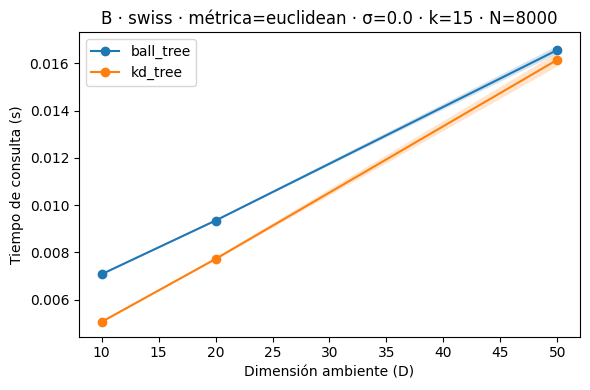

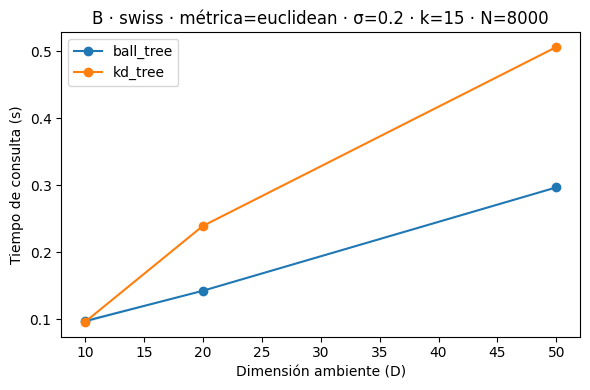

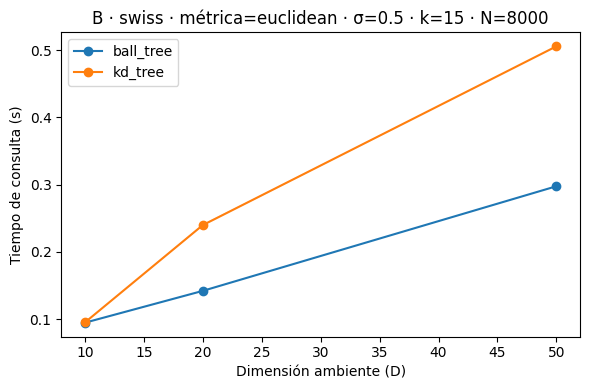

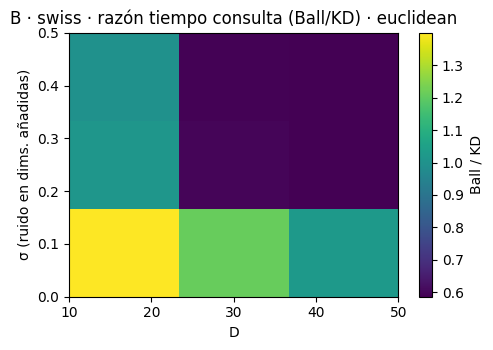

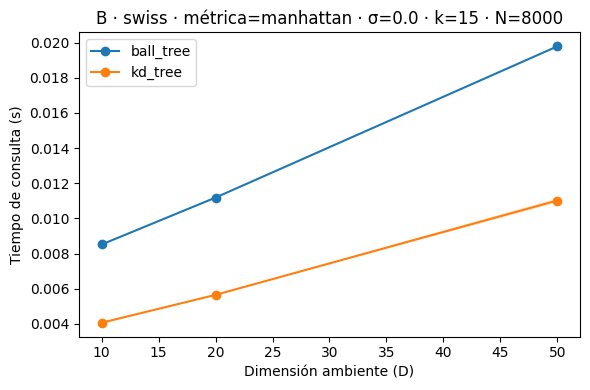

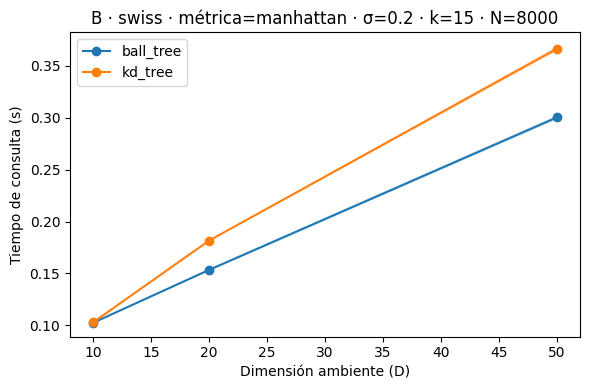

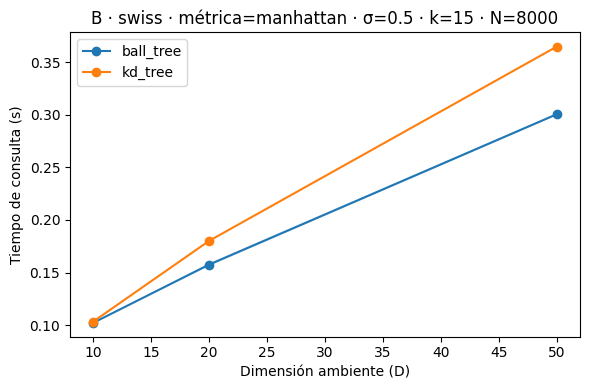

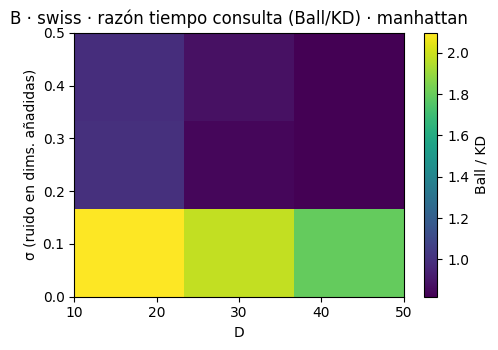

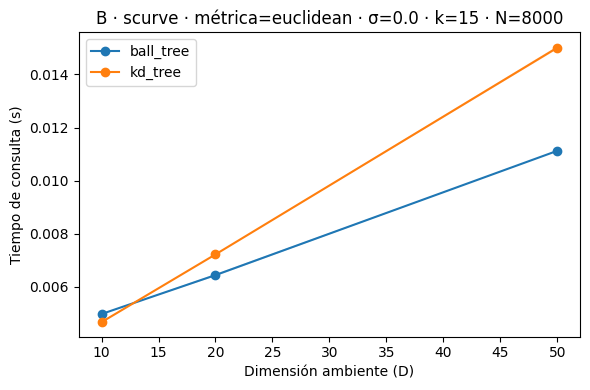

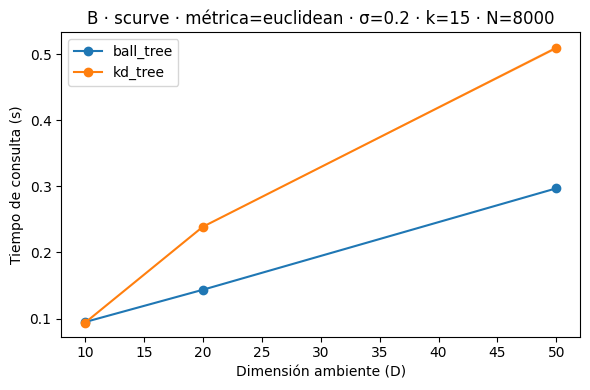

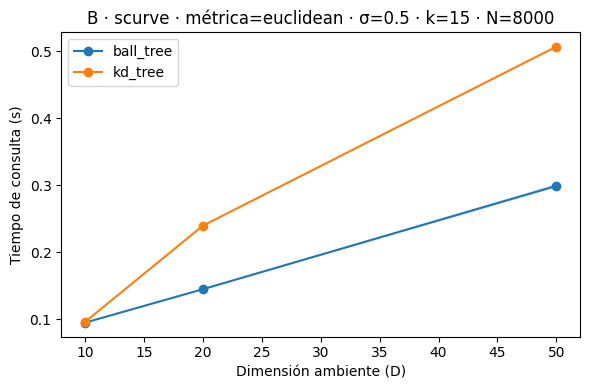

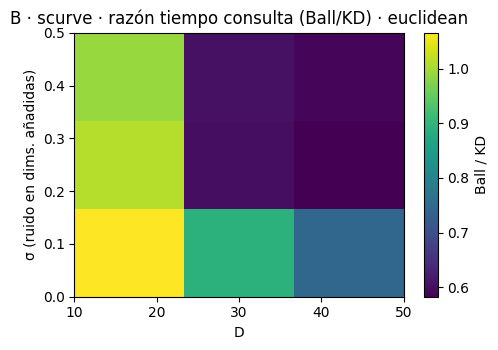

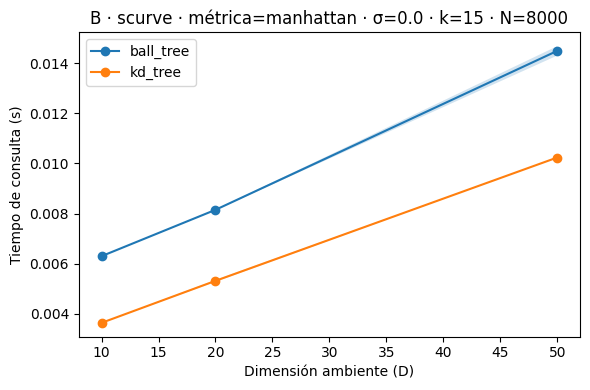

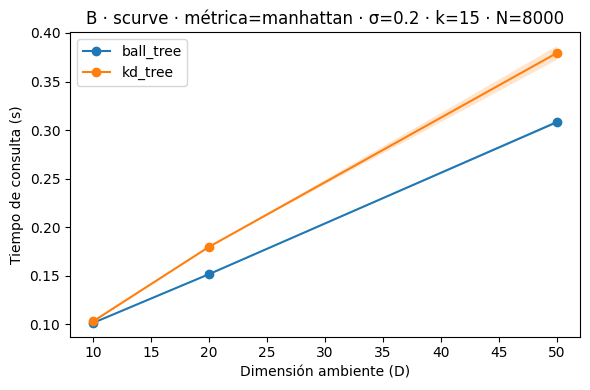

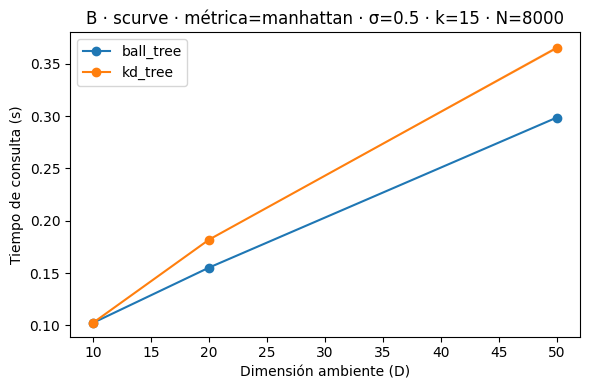

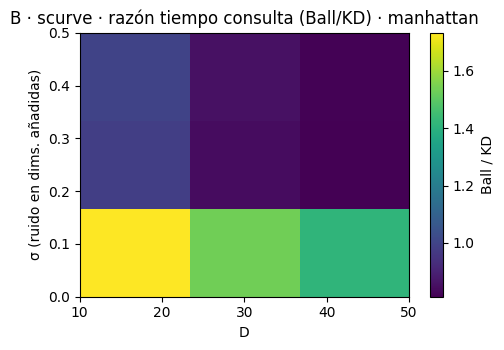

In [ ]:
def plot_manifold_curves(df, variety, metric):
    sub0 = df[(df["variety"]==variety) & (df["metric"]==metric)]
    if sub0.empty:
        return
    for sigma in SIGMA_LIST:
        sub = sub0[sub0["sigma"]==sigma]
        if sub.empty: 
            continue
        title = f"B · {variety} · métrica={metric} · σ={sigma} · k={K_B} · N={N_MANIFOLD}"
        file_out = f"B_{variety}_{metric}_sigma{sigma}_qry_vsD.png".replace(".","p")
        plot_query_vs_D(sub, title, file_out)

def plot_heatmap_ratio(df, variety, metric):
    """Mapa de calor de (Ball/KD) en la rejilla D × σ; <1 favorece Ball-Tree."""
    sub = df[(df["variety"]==variety) & (df["metric"]==metric)]
    if sub.empty: 
        return
    kd = sub[sub["algorithm"]=="kd_tree"].pivot(index="sigma", columns="D", values="qry_mean")
    bt = sub[sub["algorithm"]=="ball_tree"].pivot(index="sigma", columns="D", values="qry_mean")
    common_idx = kd.index.intersection(bt.index)
    common_cols = kd.columns.intersection(bt.columns)
    ratio = (bt.loc[common_idx, common_cols] / kd.loc[common_idx, common_cols]).values

    fig, ax = plt.subplots(figsize=(5, 3.6))
    im = ax.imshow(ratio, aspect="auto", origin="lower",
                   extent=[min(common_cols), max(common_cols), min(common_idx), max(common_idx)])
    ax.set_xlabel("D")
    ax.set_ylabel("σ (ruido en dims. añadidas)")
    ax.set_title(f"B · {variety} · razón tiempo consulta (Ball/KD) · {metric}")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Ball / KD")
    fig.tight_layout()
    fname = f"B_{variety}_{metric}_heatmap_ratio.png"
    fig.savefig(FIG_DIR / fname, dpi=150)
    plt.show()

# Curvas
for variety in ["swiss", "scurve"]:
    for metric in METRICS_B:
        plot_manifold_curves(dfB, variety, metric)
        plot_heatmap_ratio(dfB, variety, metric)

In [ ]:
# Ganador por (variety, metric, sigma, D)
winnersB = (dfB.groupby(["variety","metric","sigma","D","algorithm"])["qry_mean"]
              .median().reset_index())
idx_minB = winnersB.groupby(["variety","metric","sigma","D"])["qry_mean"].idxmin()
bestB = winnersB.loc[idx_minB].sort_values(["variety","metric","sigma","D"]).reset_index(drop=True)
bestB.to_csv(RES_DIR / "B_manifold_best_by_scenario.csv", index=False)
bestB

# % de victorias por variedad y métrica
winrateB = (bestB.groupby(["variety","metric"])["algorithm"]
            .value_counts(normalize=True)
            .mul(100).round(1).rename("porcentaje").reset_index())
winrateB.to_csv(RES_DIR / "B_manifold_winrate.csv", index=False)
winrateB

,variety,metric,algorithm,porcentaje
0,scurve,euclidean,ball_tree,77.8
1,scurve,euclidean,kd_tree,22.2
2,scurve,manhattan,ball_tree,66.7
3,scurve,manhattan,kd_tree,33.3
4,swiss,euclidean,ball_tree,55.6
5,swiss,euclidean,kd_tree,44.4
6,swiss,manhattan,ball_tree,66.7
7,swiss,manhattan,kd_tree,33.3


: 